# Comparision of generated trace vs actual trace

Validates a single experiment run by comparing the generated load vs the actual load.

Usage: Configure data source under `apps_path` and `logs_path` (statically or via app + execution)

In [59]:
# Imports
import json
from pathlib import Path
from datetime import timedelta
from dateutil.parser import parse
import pandas as pd
import numpy as np
from plotnine import *
from functools import reduce
import yaml

In [60]:
# Configure paths
data_path = Path('/Users/joe/Documents/Datasets/serverless-study/data')
apps_path = data_path / 'lg3/ec2-user'
# index for app + execution
app = 8
execution = 2
# NOTE: could derive this from sb_config
wl_types = ['constant', 'bursty', 'jump', 'spikes']
# workload_type = wl_types[execution]
workload_type = 'spikes'
workload_trace = '20rps_20min'
apps = [
    'faas-migration/ThumbnailGenerator/Lambda/thumbnail_benchmark.py',
    'faas-migration/MatrixMultiplication/Lambda/matrix_multiplication_benchmark.py',
    'faas-migration/Event-Processing/Lambda/event_processing_benchmark.py',
    'aws-serverless-workshops/ImageProcessing/image_processing_benchmark.py',
    'faas-migration-go/aws/todo_api_benchmark.py',
    'hello-retail/hello_retail_benchmark.py',
    'realworld-dynamodb-lambda/realworld_benchmark.py',
    'serverless-faas-workbench/aws/cpu-memory/video_processing/vprocessing_benchmark.py',
    'serverless-faas-workbench/aws/cpu-memory/model_training/mtraining_benchmark.py'
]
app_logs_path = apps_path / Path(apps[app]).parent / 'logs'
execution_paths = []
if app_logs_path.is_dir():
    execution_paths = [x for x in app_logs_path.iterdir() if x.is_dir()]
# dynamic
# logs_path = execution_paths[execution]
# static
# exp72_50_change: 2021-08-30_09-21-58
# exp71_50_constant: 2021-08-30_09-34-20
# exp72_100_change: 2021-08-30_09-53-20
# exp71_100_constant: 2021-08-30_10-04-11
logs_path = apps_path / 'faas-migration/ThumbnailGenerator/Lambda/logs/2021-04-30_01-09-33'
workload_traces_path = data_path / 'workload_traces'
patterns_path = workload_traces_path / workload_trace

# Invocation patterns per minute based on the Azure Function traces
patterns_path = patterns_path / f"{workload_type}.csv"
# Generated workload options using a FractionalBrownianMotion model
workload_path = logs_path / 'workload_options.json'
# Actual invocations log from k6
invocations_path = logs_path / 'k6_metrics.csv'
# Based on AWS XRay traces
traces_path = logs_path / 'trace_breakdown.csv'
invalid_path = logs_path / 'invalid_traces.csv'
# Sb config
config_path = logs_path / 'sb_config.yml'
    

In [61]:
sb_config = {}
app_config = {}
app = ''
if config_path.is_file():
    with open(config_path) as f:
        sb_config = yaml.load(f, Loader=yaml.FullLoader)
    app = list(sb_config.keys())[0]
    # Workaround for cases where sb is the first key
    if app == 'sb':
        app = list(sb_config.keys())[1]
    app_config = sb_config[app]

In [62]:
# Read invocation patterns csv
patterns_df = pd.read_csv(patterns_path)
# patterns_df.head()

In [63]:
# Standardize invocation patterns
# Expand into per invocations per second (ips)
patterns_df['patterns_ips'] = patterns_df['InvocationsPerMinute'] / 60
patterns_dup = patterns_df.append([patterns_df]*59).sort_index()
# Add relative time starting from 0 seconds
patterns_dup['relative_time'] = patterns_dup.reset_index().index
patterns_result = patterns_dup[['relative_time', 'patterns_ips']]

# grouping optional (loosing average info and accuracy)
# patterns_end = patterns_dup['relative_time'].max()
# patterns_grouped = patterns_dup.groupby(pd.cut(patterns_dup['relative_time'], np.arange(0, patterns_end, 1), include_lowest=True)).count()

In [64]:
# Read generated workload json with per-second invocation rates
with open(workload_path) as json_file:
    workload_options = json.load(json_file)
    stages = workload_options['scenarios']['benchmark_scenario']['stages']
    workload_df = pd.DataFrame.from_dict(stages, orient='columns')
# workload_df.head()

In [65]:
# Expand target-duration pairs into invocations per second (ips)
rows = []
time = 0
for duration, target in zip(workload_df['duration'], workload_df['target']):
    # # millisecond-based (quickfix)
    # num_ms = int(duration.split('ms')[0])
    # if num_ms == 1:
    #     rows.append([time, target])
    #     time += 1
    # seconds-based (standard)
    num_seconds = int(duration.split('s')[0])
    for _ in range(num_seconds):
        rows.append([time, target])
        time += 1

# Create df from list
workload_res = pd.DataFrame(rows, columns=['relative_time', 'workload_ips'])
workload_result = workload_res[['relative_time', 'workload_ips']]

In [66]:
# Read k6 invocation metrics csv log
invocations_raw = pd.read_csv(invocations_path)

vus_df = invocations_raw[invocations_raw.metric_name.eq('vus')]
# vus_df.head()

invocations_df = invocations_raw[invocations_raw.metric_name.eq('http_reqs')]
# Parse trace_id from extra_tags
invocations_df['trace_id'] = invocations_df['extra_tags'].map(lambda tags: tags.replace('xray_header=Root=', ''))
# invocations_df.head()

ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [67]:
# Read traces csv based on sb trace analyzer output
traces_df = pd.read_csv(traces_path)
# see CSV_FIELDS in aws_trace_analyzer.py
timedelta_cols = [
    'duration',
    'orchestration',
    'trigger',
    'container_initialization',
    'runtime_initialization',
    'computation',
    'queing',
    'overhead',
    'external_service',
    'unclassified'
]
# Parse timedelta fields
traces_df[timedelta_cols] = traces_df[timedelta_cols].apply(pd.to_timedelta)
num_valid_traces = len(traces_df)
# traces_df.head()

In [68]:
# Read invalid traces csv based on sb trace analyzer output
invalid_df = pd.read_csv(invalid_path)
num_invalid_traces = len(invalid_df)
# invalid_df.head()

In [69]:
# combine valid and invalid traces
all_traces_df = pd.concat([traces_df, invalid_df], ignore_index=True)
num_all_traces = len(all_traces_df)
print(f"num_all_traces={num_all_traces}")

num_invocations = len(invocations_df)
print(f"num_invocations={num_invocations}")

# merge all traces (valid + invalid) into single df
all_traces_df.join(invocations_df.set_index('trace_id'), on='trace_id', rsuffix='_invocations')
num_connected_traces = len(all_traces_df)
print(f"num_connected_traces={num_connected_traces}")
missing_trace_connections = len(invocations_df) - len(all_traces_df)
print(f"missing_trace_connections={missing_trace_connections}")

num_all_traces=22284
num_invocations=22468
num_connected_traces=22284
missing_trace_connections=184


In [70]:
# Calculate relative time in seconds since first request for epoc time-based metrics

# timestamp in epoc time (second precison)
invocations_start = invocations_df['timestamp'].min()
invocations_df['relative_time'] = invocations_df['timestamp'] - invocations_start

vus_start = vus_df['timestamp'].min()
vus_df['relative_time'] = vus_df['timestamp'] - vus_start

# start_time in epoc time (millisecond precision with 3 digits after the period dot)
traces_start = traces_df['start_time'].min()
traces_df['relative_time'] = traces_df['start_time'] - traces_start
traces_df = traces_df.sort_values(by=['relative_time'])
# traces_df.head()

ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
# Invocations and traces assume t=0 on the first request.
# Ajust for scenarios that start with target=0 by inserting 0 ips row accordingly.
offset_seconds = 0
if workload_df['target'].values[0] == 0:
    offset = workload_df['duration'].values[0]
    offset_seconds = int(offset.split('s')[0])
    print(f"offset={offset_seconds}")
    

# Group time-based metrics by second bins
invocations_end_relative = invocations_df['relative_time'].max()
invocations_grouped = invocations_df.groupby(pd.cut(invocations_df['relative_time'], np.arange(0, invocations_end_relative, 1), include_lowest=True)).count()
invocations_grouped['invocations_ips'] = invocations_grouped['name']
invocations_result = invocations_grouped[['invocations_ips']].reset_index()
invocations_result['relative_time'] = np.arange(offset_seconds, len(invocations_result)+offset_seconds)
# Adjust for offset
offset_invocations = [{'relative_time': index, 'invocations_ips': 0} for index, x in enumerate(range(offset_seconds))]
invocations_result = pd.concat([pd.DataFrame(offset_invocations), invocations_result], ignore_index=True)

traces_end_relative = traces_df['relative_time'].max()
traces_grouped = traces_df.groupby(pd.cut(traces_df['relative_time'], np.arange(0, traces_end_relative, 1), include_lowest=True)).count()
traces_grouped['traces_ips'] = traces_grouped['trace_id']
traces_result = traces_grouped[['traces_ips']].reset_index()
traces_result['relative_time'] = np.arange(offset_seconds, len(traces_result)+offset_seconds)
# Adjust for offset
traces_invocations = [{'relative_time': index, 'traces_ips': 0} for index, x in enumerate(range(offset_seconds))]
traces_result = pd.concat([pd.DataFrame(traces_invocations), traces_result], ignore_index=True)

# traces_result.head()

In [72]:
# Merge dfs
data_frames = [patterns_result, workload_result, invocations_result, traces_result]

# Compare lengths
for d in data_frames:
    print(len(d))

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['relative_time'], how='outer'), data_frames)
# df_merged.head(10)

# df_long = pd.wide_to_long(df_merged, ['A'], i='relative_time', j="type")
df_long = pd.melt(df_merged, id_vars='relative_time', value_vars=['patterns_ips', 'workload_ips', 'invocations_ips', 'traces_ips'], var_name='variable', value_name='invocations_per_second')
# df_long.head(10)

1200
1200
1193
1199


# Workload Validation


In [73]:
num_client_errors = len(traces_df[traces_df['errors']>0])
num_throttles = len(traces_df[traces_df['throttles']>0])
num_server_faults = len(traces_df[traces_df['faults']>0])
num_success_traces = len(traces_df[(traces_df['errors']==0) & (traces_df['throttles']==0) & (traces_df['faults']==0)])
# traces_df.head()

In [74]:
# Source: event_log.py from sb

def decode_event(event_string):
    event = event_string.split(',')
    event_time = parse(event[0])
    event_name = event[1]
    event_type = event[2]
    return (event_time, event_name, event_type)

def event_duration(events, name):
    """Returns the duration of the last event with the given name
    or None if no matching start and end timestamps exist.
    Example: event_duration('invoke')."""
    # scan events backwards for matching end and start times
    end_time = None
    start_time = None
    for event_string in reversed(events):
        event_time, event_name, event_type = decode_event(event_string)
        if event_name == name:
            if event_type == 'end':
                end_time = event_time
            elif event_type == 'start':
                start_time = event_time
                # found matching end-start pair
                if end_time:
                    return end_time - start_time
                # start_time without matching end_time:
                # either in progress or aborted
                # else:
                #     return None
    return None

In [75]:
summary = {}
# Experiment metadata
exp_plans = sorted(apps_path.glob('exp*.py'))
label = ''
if exp_plans:
    label = exp_plans[0].name
summary['label'] = label
summary['relative_path'] = logs_path.relative_to(apps_path)
summary['invocations_start_time'] = invocations_start
summary['traces_start_time'] = traces_start

# Deployment metadata
summary['app'] = app
summary['region'] = app_config.get('region', '')
summary['provider'] = app_config.get('provider', '')
summary['workload_type'] = app_config.get('workload_type', '')
summary['workload_trace'] = app_config.get('workload_trace', '')
summary['scale_type'] = app_config.get('scale_type', '')
summary['scale_factor'] = app_config.get('scale_factor', '')
summary['traces_filesize'] = traces_path.stat().st_size  # in bytes
events = app_config.get('sb_event_log', [])
summary['prepare_duration'] = event_duration(events, 'prepare')
summary['invoke_duration'] = event_duration(events, 'invoke')
summary['relative_time_duration'] = timedelta(seconds=traces_end_relative)

# Number of requests, traces, and error rates
summary['sent_requests'] = num_invocations
summary['missing_requests'] = missing_trace_connections
summary['missing_rate'] = round(missing_trace_connections / num_invocations * 100, 2)
summary['received_requests'] = num_all_traces
summary['invalid_traces'] = num_invalid_traces
summary['invalid_rate'] = round(num_invalid_traces / num_all_traces * 100, 2)
summary['valid_traces'] = num_valid_traces
summary['client_errors'] = num_client_errors
summary['throttles'] = num_throttles
summary['server_faults'] = num_server_faults
summary['error_traces'] = num_valid_traces - num_success_traces
summary['error_rate'] = round(summary['error_traces'] / num_valid_traces * 100, 2)
summary['success_traces'] = num_success_traces

# write csv
summary_df = pd.DataFrame(summary, index=[0])
summary_path = logs_path / 'summary.csv'
# done as batch by the validation script
# summary_df.to_csv(summary_path, index=False)

# json
summary

{'label': 'exp31.py',
 'relative_path': PosixPath('faas-migration/ThumbnailGenerator/Lambda/logs/2021-04-30_01-09-33'),
 'invocations_start_time': 1619744992,
 'traces_start_time': 1619744986.967,
 'app': 'thumbnail_generator',
 'region': 'eu-west-1',
 'provider': 'aws',
 'workload_type': 'custom',
 'workload_trace': '/home/ec2-user/20rps/spikes.csv',
 'scale_type': 'linear',
 'scale_factor': 1,
 'traces_filesize': 15093708,
 'prepare_duration': datetime.timedelta(seconds=127, microseconds=633140),
 'invoke_duration': datetime.timedelta(seconds=1213, microseconds=547461),
 'relative_time_duration': datetime.timedelta(seconds=1199, microseconds=423000),
 'sent_requests': 22468,
 'missing_requests': 184,
 'missing_rate': 0.82,
 'received_requests': 22284,
 'invalid_traces': 22,
 'invalid_rate': 0.1,
 'valid_traces': 22262,
 'client_errors': 6,
 'throttles': 0,
 'server_faults': 6,
 'error_traces': 6,
 'error_rate': 0.03,
 'success_traces': 22256}

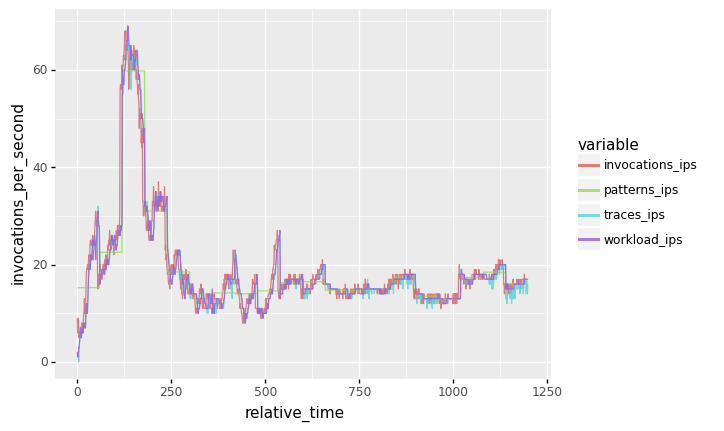

<ggplot: (305474485)>

In [84]:
# Comparison plot

# per_second_rates = patterns_dup['invocations_per_second']
# ggplot() +\
#     geom_line(aes(x=range(len(per_second_rates)), y=per_second_rates)) +\
#     geom_vline(aes(xintercept=range(0, 1250, 60)))
gen = ['patterns_ips', 'workload_ips']
k6 = ['workload_ips', 'invocations_ips']
impl = ['invocations_ips', 'traces_ips']
all_ips = ['patterns_ips', 'workload_ips', 'invocations_ips', 'traces_ips']
sources = all_ips
df_filtered = df_long[df_long.variable.isin(sources)]

(
    ggplot(df_filtered)
    + aes(x='relative_time', y='invocations_per_second', color='variable')
    + geom_line(alpha=0.8)
    # Minute separators
    # + geom_vline(xintercept=range(0, 1250, 60), color='lightgrey')
)

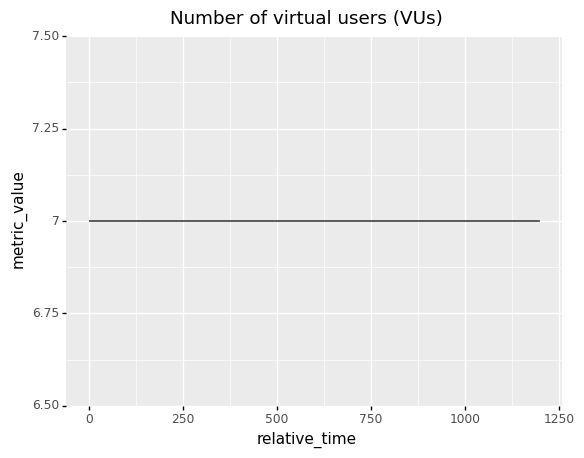

<ggplot: (304745145)>

In [77]:
# Number of k6 virtual users (i.e., concurrency)
# TODO: should align relative time with invocations_ips
(
    ggplot(vus_df)
    + aes(x='relative_time', y='metric_value')
    + geom_line()
    + ggtitle('Number of virtual users (VUs)')
    # Minute separators
    # + geom_vline(xintercept=range(0, 1250, 60), color='lightgrey')
)

# Trace characterization

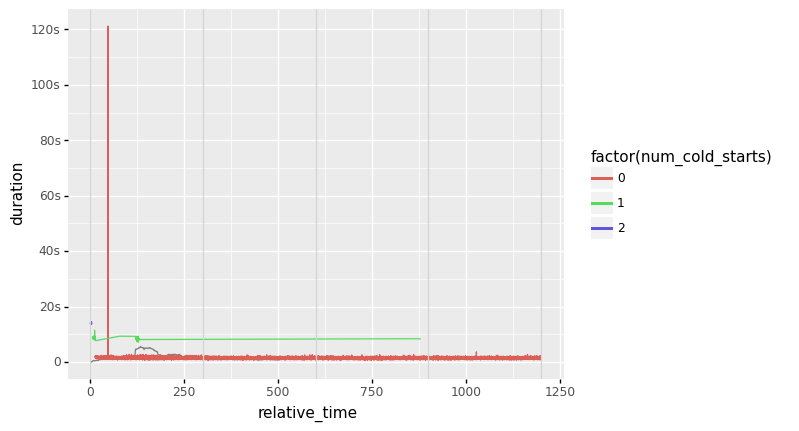

<ggplot: (305074593)>

In [78]:
# Scale traces ips to align with mean of trace duration
duration_mean = traces_df['duration'].mean()
traces_ips_mean = traces_result['traces_ips'].mean()
traces_result['traces_ips_scaled'] = traces_result['traces_ips'] * (duration_mean / traces_ips_mean)

# optionally filter by cold starts (e.g., if higher cold starts suffer from exceedingly long trace durations)
# filtered = traces_df[traces_df['num_cold_starts']<1]
# filtered = traces_df[traces_df['duration'] < timedelta(seconds=10)]
(
    ggplot(traces_df)
    # Trying to indicate load over time
    + geom_line(aes(x='relative_time', y='traces_ips_scaled'), data=traces_result, color='grey')
    + aes(x='relative_time', y='duration')
    + geom_line(aes(color='factor(num_cold_starts)'))
    # 5-minute separators
    + geom_vline(xintercept=range(0, 1500, 300), color='lightgrey')
    # Minute separators
    # + geom_vline(xintercept=range(0, 1250, 60), color='lightgrey')
)

/Users/joe/.pyenv/versions/explore-env/lib/python3.7/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals


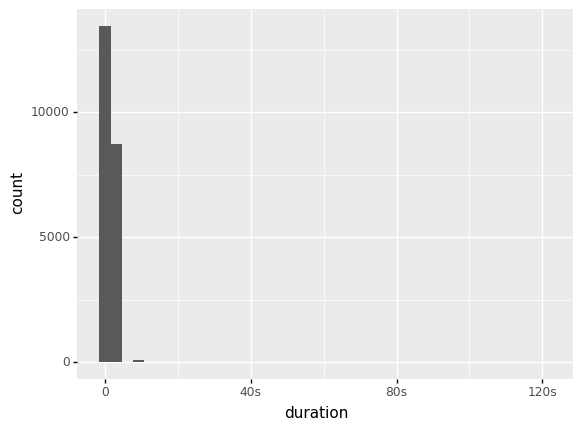

<ggplot: (305157049)>

In [79]:
(
    ggplot(traces_df)
    + aes(x="duration")
    + stat_bin(bins=40)
    + geom_bar()
)

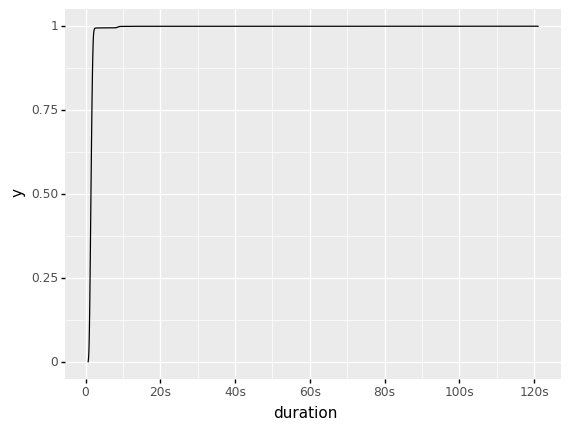

<ggplot: (306656045)>

In [80]:
(
    ggplot(traces_df)
    + aes(x="duration")
    + stat_ecdf(geom='step', position='identity', na_rm=False, n=None)
)

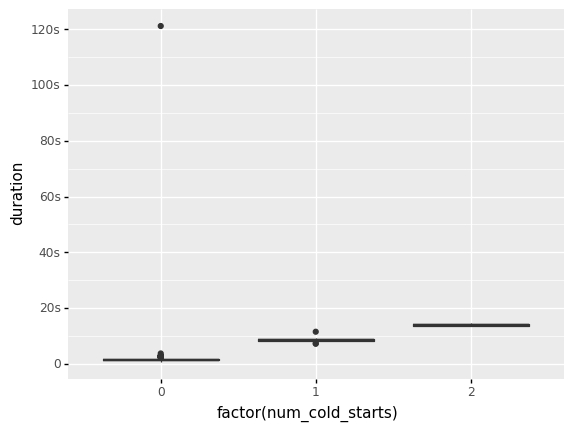

<ggplot: (306654733)>

In [81]:
(
    ggplot(traces_df)
    + aes(x="factor(num_cold_starts)", y="duration")
    + geom_boxplot() # or geom_violin()
)

/Users/joe/.pyenv/versions/explore-env/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 399'. Pick better value with 'binwidth'.


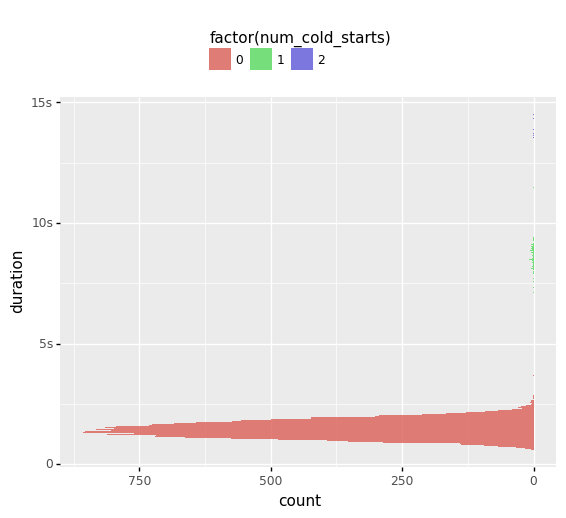

<ggplot: (306813573)>

In [82]:
no_outliers = traces_df[traces_df['duration'] < timedelta(seconds = 20)]
(
    ggplot(no_outliers)
    + aes(x="duration", fill="factor(num_cold_starts)")
    + geom_histogram(alpha=0.8)
    + coord_flip()
    + scale_y_reverse()
    + theme(legend_position='top')
)

In [83]:
traces_df.describe(percentiles=[.5, .95, .99])

,start_time,end_time,duration,num_cold_starts,errors,throttles,faults,orchestration,trigger,container_initialization,runtime_initialization,computation,queing,overhead,external_service,unclassified,relative_time
count,2.226200e+04,2.226200e+04,22262,22262.000000,22262.000000,22262.0,22262.000000,22262,22262,111,111,22262,22262,0,22262,22262,22262.000000
mean,1.619746e+09,1.619746e+09,0 days 00:00:01.500776884,0.005301,0.000539,0.0,0.000270,0 days 00:00:00.029119665,0 days 00:00:01.140429925,0 days 00:00:00.238522522,0 days 00:00:01.304900900,0 days 00:00:00.125076003,0 days 00:00:00.060065672,NaT,0 days 00:00:00.138389991,0 days 00:00:00,523.396968
std,3.597168e+02,3.596281e+02,0 days 00:00:01.021505841,0.076822,0.032830,0.0,0.016415,0 days 00:00:00.023088664,0 days 00:00:00.863271397,0 days 00:00:00.223442156,0 days 00:00:00.694247283,0 days 00:00:00.323246075,0 days 00:00:00.044391866,NaT,0 days 00:00:00.126528881,0 days 00:00:00,359.716829
min,1.619745e+09,1.619745e+09,0 days 00:00:00.597000,0.000000,0.000000,0.0,0.000000,0 days 00:00:00.017000,0 days 00:00:00.292000,-1 days +23:59:58.926000,0 days 00:00:01.004000,0 days 00:00:00.042000,0 days 00:00:00.010000,NaT,0 days 00:00:00.069000,0 days 00:00:00,0.000000
50%,1.619745e+09,1.619745e+09,0 days 00:00:01.445000,0.000000,0.000000,0.0,0.000000,0 days 00:00:00.027000,0 days 00:00:01.122000,0 days 00:00:00.257000,0 days 00:00:01.131000,0 days 00:00:00.116000,0 days 00:00:00.052000,NaT,0 days 00:00:00.115000,0 days 00:00:00,475.172500
95%,1.619746e+09,1.619746e+09,0 days 00:00:02.033000,0.000000,0.000000,0.0,0.000000,0 days 00:00:00.038000,0 days 00:00:01.671000,0 days 00:00:00.524000,0 days 00:00:03.932500,0 days 00:00:00.173000,0 days 00:00:00.104000,NaT,0 days 00:00:00.211000,0 days 00:00:00,1129.152150
99%,1.619746e+09,1.619746e+09,0 days 00:00:02.331389999,0.000000,0.000000,0.0,0.000000,0 days 00:00:00.078000,0 days 00:00:01.814000,0 days 00:00:00.571200,0 days 00:00:03.984400,0 days 00:00:00.294389999,0 days 00:00:00.182000,NaT,0 days 00:00:00.643779999,0 days 00:00:00,1185.289790
max,1.619746e+09,1.619746e+09,0 days 00:02:01.206000,2.000000,2.000000,0.0,1.000000,0 days 00:00:01.158000,0 days 00:02:00.873000,0 days 00:00:00.622000,0 days 00:00:04.021000,0 days 00:00:06.690000,0 days 00:00:02.368000,NaT,0 days 00:00:03.401000,0 days 00:00:00,1199.423000
